## 3D VQ-VAE (Vector-Quantized Variational Autoencoder)

An example implementation of a three-dimensional (3D) Vector-Quantized Variational Autoencoder (VQ-VAE) prototype, here used for the compression task of 3D data cubes. This 3D VQ-VAE is an extension of the 2D version developed by [airalcorn2](https://github.com/airalcorn2/vqvae-pytorch/tree/master). The model comprises of ResNet Encoder and Decoder modules, as well as the Vector Quantization module at the bottleneck. The main motivation for using a VQ-VAE for this compression task is that the vector quantization should produce efficient compressions due to the sparsity in these data. The example 3D data cube used here is a 3D Velocity Distribution Function (VDF) simulated by Vlasiator.

Vlasiator [@palmroth2018](https://pubmed.ncbi.nlm.nih.gov/30680308/) is an open-source simulation software used to model the behavior of plasma in the Earth's magnetosphere, a region of space where the solar wind interacts with the Earth’s magnetic field. Vlasiator models collisionless space plasma dynamics by solving the 6-dimensional Vlasov equation, using a hybrid-Vlasov approach. It uses a 3D Cartesian grid in real space, with each cell storing another 3D Cartesian grid in velocity space. The 3D VDF cube we use as an example here is the representation of a single cell in the velocity space. Here's an example of the magnetospheric simulation produced by Vlasiator (credits to Markku Alho and Kostis Papadakis for the following visualization).

![title](images/egi.png)


### Imports

In [10]:
import tools as project_tools
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

### Loading a VDF data cube

In [2]:
input_cube = np.load("vdf_sample.npy")

### 3D VQ-VAE

In [3]:
class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv3d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv3d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv3d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=5,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv3d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=1,
        )

        self.tconv = nn.ConvTranspose3d(
            in_channels=num_hiddens,
            out_channels=num_hiddens,
            kernel_size=5,
            stride=1,
            padding=1,
        )
        
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, 1)#3)

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose3d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    #output_padding=(1,1,1),
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        h = self.tconv(h)
        h = nn.ReLU()(h)
        x_recon = self.upconv(h)
        return x_recon


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay ** self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3 ** 0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 4, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x ** 2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts ** 2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 4, 1, 2, 3)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv3d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, _) = self.quantize(x)
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
        }

#### Initializations and model parameters

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

use_tb = True # Use Tensorboard

# Initialize model
use_ema = True # Use exponential moving average
model_args = {
    "in_channels": 1,
    "num_hiddens": 128,
    "num_downsampling_layers": 2,
    "num_residual_layers": 2,
    "num_residual_hiddens": 32,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "use_ema": use_ema,
    "decay": 0.99,
    "epsilon": 1e-5,
}
model = VQVAE(**model_args).to(device)

# Initialize dataset
batch_size = 1
workers = 1

input_norm = (input_cube - input_cube.min())/(input_cube.max() - input_cube.min()) # MinMax normalization
input_tensor = torch.tensor(input_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions, move to device
train_dataset = input_tensor
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
)

# Multiplier for commitment loss. See Equation (3) in "Neural Discrete Representation Learning"
beta = 0.25

# Initialize optimizer
train_params = [params for params in model.parameters()]
lr = 3e-4
optimizer = optim.Adam(train_params, lr=lr)
criterion = nn.MSELoss()

# Train model
epochs = 30
eval_every = 1
best_train_loss = float("inf")
model.train()

Using device: cpu


VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu0): ReLU()
      (down1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu1): ReLU()
      (final_conv): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): ReLU()
          (1): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (2): ReLU()
          (3): Conv3d(32, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv3d(128, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage()
  )
  (decoder): Decoder(
    (conv): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
 

In [5]:
# Util for Tensorboard plotting in color
def prep_fig(img):
    fig, ax = plt.subplots()
    im = ax.imshow(img, interpolation='none')
    #plt.colorbar(im, ax=ax)

    fig.canvas.draw()
    plt.close()

    return fig

#### Training prototype (uses only a single sample cube at the moment)

In [6]:
# Tensorboard setup
if use_tb:
    writer = SummaryWriter("runs/3D_VQ-VAE_run1")

# Training
for epoch in tqdm(range(epochs)):
    total_train_loss = 0
    total_recon_error = 0
    n_train = 0
    for (batch_idx, train_tensors) in enumerate(train_loader):
        optimizer.zero_grad()
        imgs = train_tensors[0].unsqueeze(0).to(device)
        out = model(imgs)
        recon_error = criterion(out["x_recon"], imgs) #/ train_data_variance
        total_recon_error += recon_error.item()
        loss = recon_error + beta * out["commitment_loss"]
        if not use_ema:
            loss += out["dictionary_loss"]

        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        n_train += 1

        if ((batch_idx + 1) % eval_every) == 0:
            print(f"epoch: {epoch}\nbatch_idx: {batch_idx + 1}", flush=True)
            total_train_loss /= n_train
            if total_train_loss < best_train_loss:
                best_train_loss = total_train_loss

            print(f"total_train_loss: {total_train_loss}")
            writer.add_scalar("tr loss: ", total_train_loss, epoch)

            print(f"best_train_loss: {best_train_loss}")
            print(f"recon_error: {total_recon_error / n_train}\n")

            total_train_loss = 0
            total_recon_error = 0
            n_train = 0

    if use_tb:
        # write to tensorboard
        writer.add_figure('reconstructed VDF', prep_fig(out["x_recon"].squeeze(0).squeeze(0)[:,:,25].detach().numpy()), epoch)

if use_tb:
    writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 0
batch_idx: 1
total_train_loss: 0.4812563359737396
best_train_loss: 0.4812563359737396
recon_error: 0.30013811588287354

epoch: 1
batch_idx: 1
total_train_loss: 9.730546951293945
best_train_loss: 0.4812563359737396
recon_error: 9.727148056030273

epoch: 2
batch_idx: 1
total_train_loss: 0.23720860481262207
best_train_loss: 0.23720860481262207
recon_error: 0.22696828842163086

epoch: 3
batch_idx: 1
total_train_loss: 0.11654067039489746
best_train_loss: 0.11654067039489746
recon_error: 0.09062690287828445

epoch: 4
batch_idx: 1
total_train_loss: 0.15647533535957336
best_train_loss: 0.11654067039489746
recon_error: 0.11193650215864182

epoch: 5
batch_idx: 1
total_train_loss: 0.17595776915550232
best_train_loss: 0.11654067039489746
recon_error: 0.11274047940969467

epoch: 6
batch_idx: 1
total_train_loss: 0.17336143553256989
best_train_loss: 0.11654067039489746
recon_error: 0.08786721527576447

epoch: 7
batch_idx: 1
total_train_loss: 0.213847815990448
best_train_loss: 0.1165406703948

In [7]:
# Save model checkpoint
#torch.save({
#    'epoch': epochs,
#    'model_state_dict': model.state_dict(),
#    'optimizer_state_dict': optimizer.state_dict()
#    }, "./VQ-VAE_checkpoints/.pt")

#### Plot reconstruction of VDF cube

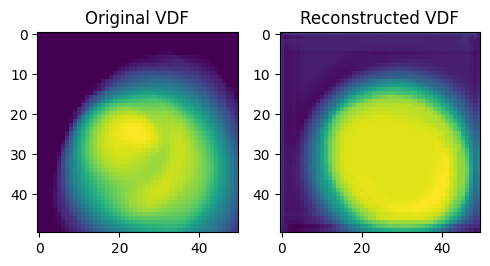

In [9]:
rec_vdf = out["x_recon"].squeeze(0).squeeze(0).detach().numpy()
rec_vdf_rescaled = (rec_vdf*(np.amax(input_cube) - np.amin(input_cube))) + np.amin(input_cube)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(input_cube[:,:,25])
axes[0].set_title("Original VDF")
axes[1].imshow(rec_vdf_rescaled[:,:,25])
axes[1].set_title("Reconstructed VDF")
fig.tight_layout()
plt.show()